# Convergence analysis for a cantilever beam


This notebook presents convergence analysis using the Finite Element
Method for a cantilever beam.

The following figure shows a cantelever beam under a tip load $P$. The beam is of length $l$;
moment of inertia $I$; height $2c$ and material properties corresponding
to Poissons ratio and Young modulos $\nu$ and $E$ respectively.

<center><img src="./img/cantilever_beam.svg" alt="Cantilever beam" style="width:600px"></center>

The analytic solution is given by (see Timoshenko):

$$u =  - \frac{P}{{2EI}}{x^2}y - \frac{{\nu P}}{{6EI}}{y^3} + \frac{P}{{2IG}}{y^3} + \left( {\frac{{P{l^2}}}{{2EI}} - \frac{{P{c^2}}}{{2IG}}} \right)y$$

$$v = \frac{{\nu P}}{{2EI}}x{y^2} + \frac{P}{{6EI}}{x^3} - \frac{{P{l^2}}}{{2EI}}x + \frac{{P{l^3}}}{{3EI}}$$

$${\varepsilon _{xx}} = \frac{{\partial u}}{{\partial x}} \equiv  - \frac{P}{{EI}}xy$$

$${\varepsilon _{yy}} = \frac{{\partial v}}{{\partial y}} \equiv \frac{{\nu P}}{{EI}}xy$$

$${\gamma _{xy}} = \frac{{\partial u}}{{\partial y}} + \frac{{\partial v}}{{\partial x}} \equiv \frac{P}{{2IG}}\left( {{y^2} - {c^2}} \right)$$

The following snippet compute the solution for an array of points $x$, $y$.

In [1]:
from __future__ import division, print_function
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib import rcParams
from solidspy.preprocesor import rect_grid
import solidspy.postprocesor as pos
import solidspy.assemutil as ass
import solidspy.solutil as sol

In [2]:
%matplotlib notebook


rcParams['figure.figsize'] = 6, 4
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12

In [3]:
def beam_sln(x, y, nu, P, E, I, L, h):
    """Compute the solution for a cantilever beam

    Parameters
    ----------
    x : ndarray (float)
        Array with x coordinates.
    y : ndarray (float)
        Array with y coordinates.
    nu : float, (-1, 0.5)
        Poisson coefficient.
    P : float
        Applied force at the end of the beam.
    E : float, >0
        Young modulus.
    I : float, >0
        Moment of inertia.
    L : float, >0
        Length of the beam.
    h : float, >0
        Height of the beam.

    Returns
    -------
    u : ndarray (float)
        Horizontal displacement at the nodes.
    v : ndarray (float)
        Vertical displacement at the nodes.
    exx : ndarray (float)
        xx component of the strain tensor.
    eyy : ndarray (float)
        yy component of the strain tensor.
    gammaxy : ndarray (float)
        xy component of the strain tensor.
        
    References
    ----------
    .. [1] Timoshenko, S. & Goodier, J., 1970. Theory of Elasticity,
        McGraw-Hill, 3rd Ed.

    """
    G = E/(2*(1 + nu))
    c = h/2
    C1 = -P/(2*E*I)
    C2 = -(nu*P)/(6*E*I)
    C3 = P/(2*I*G)
    C4 = (P*L**2)/(2*E*I)
    C5 = -(P*c**2)/(2*I*G)
    C6 = C4 + C5
    C7 = (nu*P)/(2*E*I)
    C8 = P/(6*E*I)
    C9 = -(P*L**2)/(2*E*I)
    C10 = (P*L**3)/(3*E*I)
    B1 = -P/(E*I)
    B2 = (nu*P)/(E*I)
    B3 = P/(2*I*G)
    u = C1*y*x**2 + C2*y**3 + C3*y**3 + (C5 + C6)*y
    v = C7*x*y**2 + C8*x**3 + C9*x + C10
    exx = B1*x*y
    eyy = B2*x*y
    gammaxy = B3*(y**2 - c**2)

    return u, v, exx, eyy, gammaxy

In [4]:
nu, P, E, I, L, h = 0.3, -50, 1000, 42.67, 24, 4
x = np.linspace(0, L, 100)
y = np.linspace(-h, h, 100)
x, y  = np.meshgrid(x, y)
u, v, exx, eyy, gammaxy  = beam_sln(x, y, nu, P, E, I, L, h)

The particular solution for parameters $E=1000.0$, $P=-50$ $\nu=0.30$, $I=42.67$,
$l=24$ and $2c=8$ is shown below:

<IPython.core.display.Javascript object>


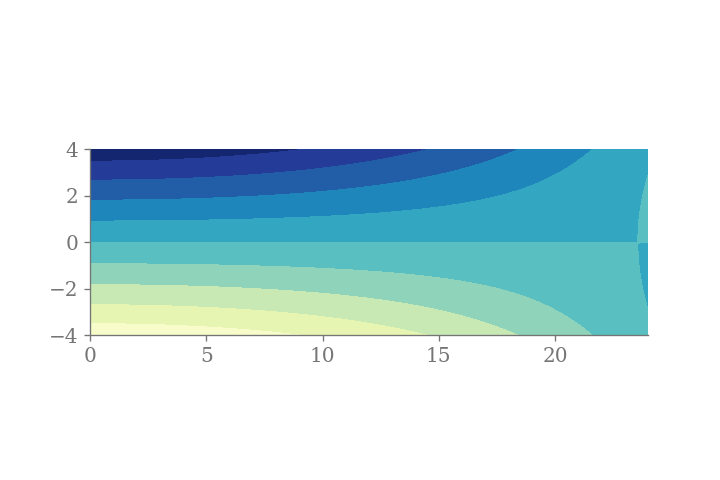

In [5]:
plt.figure()
plt.contourf(x, y, u, 10)
plt.axis("image");

<IPython.core.display.Javascript object>


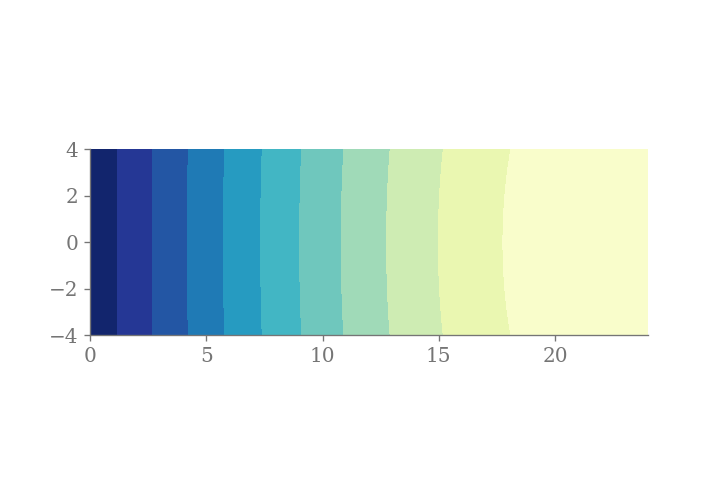

In [7]:
plt.figure()
plt.contourf(x, y, v, 10)
plt.axis("image");

We also want to analyze this problem using the FEM with bilineal square elements under plane stress conditions.

Since this is a structured mesh it is easily generated in a simple function.

In [8]:
P = -50
E = 1000
nu = 0.3
L = 24
h = 8
I = 42.67
analytic = True
niter = 8
err = np.zeros((niter))
mats = np.array([[E, nu], [E, nu]])
fname = "error_vs_h.txt"
fid = open(fname, "w")
fid.write("Iteration, Elements, h, error\n")
fid.close()

Notice that in the finite elment models the load is applied as nodal point loads of the same magnitud distributed along all the nodes at $x=-12$. This implies a uniform load distribution instead of the parabolic load that is consistent with the shear stress in the analytic solution.

In [9]:
for cont in range(1, niter + 1):
    print("Starting iteration %i, " % cont +
          "h=%g, %i elements" % (8/2**(cont - 1), 3*4**(cont - 1)))
    nx = 3*2**(cont - 1)
    ny = 2**(cont - 1)
    x, y, els = rect_grid(L, h, nx, ny)
    nodes = np.zeros(((nx + 1)*(ny + 1), 5))
    nodes[:, 0] = range((nx + 1)*(ny + 1))
    nodes[:, 1] = x
    nodes[:, 2] = y
    nodes[x==L/2, 3] = -1
    nodes[nx*(ny//2 + 1) - 1, 4] = -1    
    loads = np.zeros((ny + 1, 3))
    loads[:, 0] = nodes[x==-L/2, 0]
    loads[:, 2] = P/ny

    # Assembly
    DME, IBC, neq = ass.DME(nodes, els)
    stiff = ass.assembler(els, mats, nodes, neq, DME)
    rhs = ass.loadasem(loads, IBC, neq)

    # Solution
    disp = sol.static_sol(stiff, rhs)
    disp_comp = pos.complete_disp(IBC, nodes, disp)

    # Interpolation and error evaluation
    if cont > 1:
        disp_interp = np.column_stack([u_interp, v_interp])
        aux = np.linalg.norm(disp_interp - disp_comp)
        err[cont - 1] = aux/np.linalg.norm(disp_comp)
        fid = open(fname, "a")
        fid.write("%i, %i, %g, %g\n" %
                 (cont, 3*4**(cont - 1), 8*1/2**(cont - 1), err[cont-1]))
        fid.close()
        
    x_new, y_new, _ = rect_grid(L, h, 2*nx, 2*ny)
    u_interp = griddata((x, y), disp_comp[:, 0], (x_new, y_new))
    v_interp = griddata((x, y), disp_comp[:, 1], (x_new, y_new))

Starting iteration 1, h=8, 3 elements
Starting iteration 2, h=4, 12 elements
Starting iteration 3, h=2, 48 elements
Starting iteration 4, h=1, 192 elements
Starting iteration 5, h=0.5, 768 elements
Starting iteration 6, h=0.25, 3072 elements
Starting iteration 7, h=0.125, 12288 elements
Starting iteration 8, h=0.0625, 49152 elements


<IPython.core.display.Javascript object>


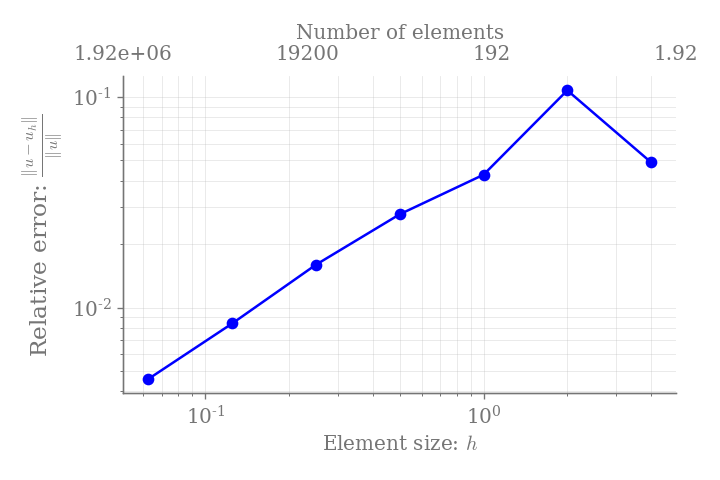

In [10]:
data = np.loadtxt("error_vs_h.txt", skiprows=1, delimiter=",")
els = data[:, 1]
h = data[:, 2]
err = data[:, 3]
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.loglog(h, err, '-bo')
plt.xlabel(r"Element size: $h$")
plt.ylabel(r"Relative error: $\frac{\Vert u - u_h \Vert}{\Vert u \Vert}$",
           fontsize=14)
xticks, xlabels = plt.xticks()
plt.grid(which="both", alpha=0.3, lw=0.5)
ax2 = ax1.twiny()
ax2.set_xscale("log")
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(xticks[1:-1])
labels = 192/4**np.log2(xticks[1:-1])
ax2.set_xticklabels(["%g"%label for label in labels])
ax2.xaxis.set_ticks_position("none")
plt.xlabel("Number of elements")
plt.tight_layout()

## Refences

1. Timoshenko, S. P. J. N. "Goodier, Theory of elasticity." McGraw-Hill Book Co., Inc., New York (1970).

The following cell gives format to the notebook.

In [11]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../custom_barba.css', 'r').read()
    return HTML(styles)
css_styling()